In [1]:
# This is for dataset loading/saving purpose in google colab, 
# If you already have your dataset locally just make sure its directory to your working directory and ignore this cell.
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [2]:
# Change to working directory
%cd /content/drive/MyDrive/ME499

/content/drive/MyDrive/ME499


In [3]:
# Define the dataset directories
train_dir = 'Face Mask Dataset/Train'
test_dir = 'Face Mask Dataset/Test'
val_dir = 'Face Mask Dataset/Validation'

In [4]:
# Make sure GPU mode is turned on 
import torch
torch.cuda.is_available()

True

In [2]:
import numpy as np
import cv2
from scipy.spatial import distance
import keras
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

In [6]:
# Data augmentation
train_data = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
train_gen= train_data.flow_from_directory(directory=train_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

val_data = ImageDataGenerator(rescale=1.0/255)
val_gen = train_data.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

test_data = ImageDataGenerator(rescale=1.0/255)
test_gen = train_data.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


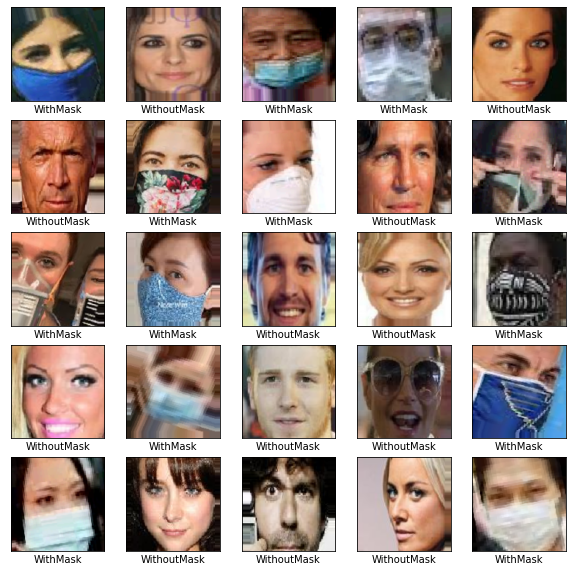

In [7]:
# Show some labeled image and make they loaded properly
import matplotlib.pyplot as plt

class_names = {v:k for k,v in train_gen.class_indices.items()}
images,labels = next(iter(train_gen))

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_names[labels[i][1]])

plt.show()

In [8]:
# Build the classification model by using VGG19 as backbone (several CNN layers for feature extraction)
vgg = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg.layers:
    layer.trainable = False
    
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 2)                 16386     
                                                                 
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


In [9]:
# Compile optimizer and loss function for model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics ="accuracy")

In [10]:
# Train the model
train_hist = model.fit_generator(generator=train_gen,
                              steps_per_epoch=len(train_gen)//32,
                              epochs=30,validation_data=val_gen,
                              validation_steps=len(val_gen)//32)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/30
9/9 [==============================] - 97s 10s/step - loss: 0.4992 - accuracy: 0.7396
Epoch 2/30
9/9 [==============================] - 30s 3s/step - loss: 0.2184 - accuracy: 0.9306
Epoch 3/30
9/9 [==============================] - 35s 4s/step - loss: 0.1949 - accuracy: 0.9132
Epoch 4/30
9/9 [==============================] - 31s 4s/step - loss: 0.1729 - accuracy: 0.9375
Epoch 5/30
9/9 [==============================] - 31s 3s/step - loss: 0.0940 - accuracy: 0.9757
Epoch 6/30
9/9 [==============================] - 32s 4s/step - loss: 0.0803 - accuracy: 0.9722
Epoch 7/30
9/9 [==============================] - 26s 3s/step - loss: 0.0832 - accuracy: 0.9757
Epoch 8/30
9/9 [==============================] - 29s 3s/step - loss: 0.1114 - accuracy: 0.9583
Epoch 9/30
9/9 [==============================] - 25s 3s/step - loss: 0.1075 - accuracy: 0.9549
Epoch 10/30
9/9 [==============================] - 29s 3s/step - loss: 0.0952 - accuracy: 0.9688
Epoch 11/30
9/9 [=====================

In [11]:
# Evaluate/test the trained model
model.evaluate_generator(test_gen)
#below shows: [loss, accurary]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[0.04337867721915245, 0.9912499785423279]

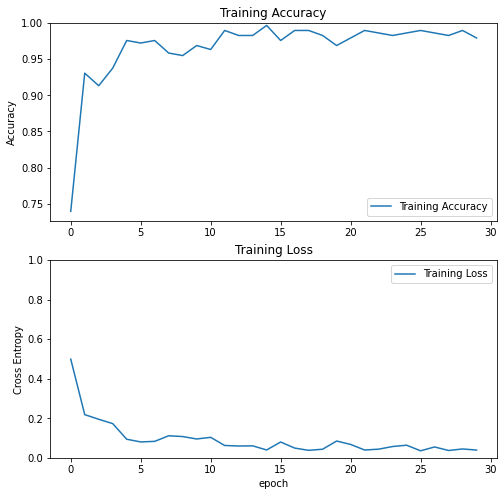

In [13]:
#Plot the accuracy history
acc = train_hist.history['accuracy']
loss = train_hist.history['loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1])
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

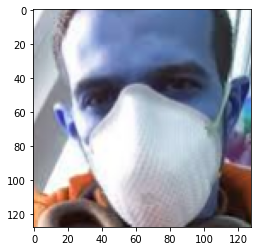

In [31]:
# Sample Test 
sample = cv2.imread( test_dir + '/WithMask/79.png')
sample = cv2.resize(sample,(128,128))
plt.imshow(sample)
sample = np.reshape(sample,[1,128,128,3])
sample = sample/255.0

In [32]:
# Varify the model predition 
model.predict(sample)
#Below shows: [P(With_mask), P(Without_make)]

array([[0.96785   , 0.00419403]], dtype=float32)

In [33]:
# Save the trained model for later 
model.save('MaskCLSNet.h5')

In [7]:
from tensorflow.keras.models import load_model

#load the saved model
CLSmodel = load_model('MaskCLSNet.h5')

# Check its architecture
CLSmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 16386     
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
#### Mask face detection and socal distance violations in real time ####
### Before running this cell, make sure to plug the realsense camera and it functions well.
from PIL import Image
from scipy.spatial import distance
import pyrealsense2 as rs
import cv2
import numpy as np

font_scale=1
thickness = 2
red = (0,0,255)
green = (0,255,0)
blue = (255,0,0)
font=cv2.FONT_HERSHEY_SIMPLEX

mask_label = {0:'Mask', 1:'No_mask'}
color_dict={0:green, 1:red}
Social_Distance = 1; # meter

### Create a pipeline
pipeline = rs.pipeline()

# Create a config and configure the pipeline to stream
#  different resolutions of color and depth streams
config = rs.config()

# Get device product line for setting a supporting resolution
pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))

found_rgb = False
for s in device.sensors:
    if s.get_info(rs.camera_info.name) == 'RGB Camera':
        found_rgb = True
        break
if not found_rgb:
    print("The demo requires Depth camera with Color sensor")
    exit(0)

config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)

## Start streaming
profile = pipeline.start(config)
# Getting the depth sensor's depth scale (see rs-align example for explanation)
depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
print("Depth Scale is: " , depth_scale)
# We will be removing the background of objects more than
#  clipping_distance_in_meters meters away
clipping_distance_in_meters = 10 #1 meter
clipping_distance = clipping_distance_in_meters / depth_scale
# Create an align object
# rs.align allows us to perform alignment of depth frames to others frames
# The "align_to" is the stream type to which we plan to align depth frames.
align_to = rs.stream.color
align = rs.align(align_to)
###
#####
prof = profile.get_stream(rs.stream.color)
intr = prof.as_video_stream_profile().get_intrinsics() #get intrinsics
#####

# face detection, using the Haar feature-based cascade classifier, 
# return the bounding box coordinates of each detected face
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Streaming loop
try:
    while True:
        print('###new frame###')
        # Get frameset of color and depth
        frame = pipeline.wait_for_frames()
        # frames.get_depth_frame() is a 1280x720 depth image
        # Align the depth frame to color frame
        aligned_frame = align.process(frame)

        # Get aligned frames
        aligned_depth_frame = aligned_frame.get_depth_frame() # aligned_depth_frame is a 640x480 depth image
        color_frame = aligned_frame.get_color_frame()

        # Validate that both frames are valid
        if not aligned_depth_frame or not color_frame:
            continue

        depth_image = np.asanyarray(aligned_depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())
        
        depth_image=cv2.flip(depth_image,1,1) #Flip to act as a mirror
        frame=cv2.flip(color_image,1,1) #Flip to act as a mirror

        # Remove background - Set pixels further than clipping_distance to grey
        grey_color = 153
        depth_image_3d = np.dstack((depth_image,depth_image,depth_image)) #depth image is 1 channel, color is 3 channels
        bg_removed = np.where((depth_image_3d > clipping_distance) | (depth_image_3d <= 0), grey_color, frame)        
        
        # convert to gray scale and extract each detected faces from each frame
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)
        
        # determine the social distance volation for each detected face-> 0 for no violation(green), 1 for violation(red)
        dis_index = [0 for i in range(len(faces))]
        for i in range(len(faces)-1):
            for j in range(i+1, len(faces)):
                (xi,yi,wi,hi) = faces[i]
                (xj,yj,wj,hj) = faces[j]
                zi = depth_image[int(yi+hi/2)][int(xi+wi/2)]*depth_scale
                zj = depth_image[int(yj+hj/2)][int(xj+wj/2)]*depth_scale
                xi_r, yi_r, zi_r =  rs.rs2_deproject_pixel_to_point(intr, [xi,yi], zi)
                xj_r, yj_r, zj_r =  rs.rs2_deproject_pixel_to_point(intr, [xj,yj], zj)
                dist = distance.euclidean([xi_r, yi_r, zi_r ], [xj_r, yj_r, zj_r])
                print('dist',dist)
                if dist<Social_Distance:
                    dis_index[i] = 1
                    dis_index[j] = 1

        #determine the mask wearing class for each detected face.
        for i in range(len(faces)):
            (x,y,w,h) = faces[i]
            z = depth_image[int(y+h/2)][int(x+w/2)]*depth_scale
            print('depth', z)
            x_real, y_real, z_real =  rs.rs2_deproject_pixel_to_point(intr, [x,y], z)
            print(x_real, y_real, z_real)
            #crop the face region
            crop = frame[y:y+h,x:x+w]
            crop = cv2.resize(crop,(128,128))
            crop = np.reshape(crop,[1,128,128,3])/255.0
            #using the loaded model to classify the crop the face region
            mask_result = CLSmodel.predict(crop) 
            #classify label
            mask_index=np.argmax(mask_result,axis=1)[0]
            
            cv2.putText(frame, mask_label[mask_index], (x,y - 10), font, font_scale, color_dict[mask_index], thickness)
            cv2.rectangle(frame, (x, y), (x+w, y+h), color_dict[dis_index[i]], 2)

        depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
        frame = np.hstack((bg_removed, frame))
        
        cv2.imshow('frame',frame)
        # Press esc or 'q' to close the image window
        key = cv2.waitKey(10)
        if key & 0xFF == ord('q') or key == 27:
            cv2.destroyAllWindows()
            break

finally:
    pipeline.stop()